In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [37]:
df = pd.read_csv('va_filtered_listings.csv')

df.head()

,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,state,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,5/1/2019,7/31/2019,90,zip code,2,9670,f,Zip Code: 24244,NaN,Virginia,...,0.100000,NaN,NaN,NaN,0.100000,0.000000,0.100000,"Kingsport, TN",28700,2/10/2025 14:21
1,6/1/2022,8/31/2022,90,zip code,2,9223,f,Zip Code: 23235,NaN,Virginia,...,0.037794,NaN,NaN,NaN,0.680272,-0.059373,-0.023216,"Richmond, VA",40060,2/10/2025 14:21
2,9/1/2024,11/30/2024,90,zip code,2,9824,f,Zip Code: 24563,NaN,Virginia,...,-0.716667,NaN,NaN,NaN,0.375000,-0.069444,0.000000,"Danville, VA",19260,2/10/2025 14:21
3,8/1/2018,10/31/2018,90,zip code,2,7894,f,Zip Code: 20187,NaN,Virginia,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,"Washington, DC",47894,2/10/2025 14:21
4,11/1/2022,1/31/2023,90,zip code,2,9224,f,Zip Code: 23236,NaN,Virginia,...,-0.084934,NaN,NaN,NaN,0.452830,-0.032464,-0.188679,"Richmond, VA",40060,2/10/2025 14:21


In [38]:
# Convert 'period_begin' to datetime, ensuring invalid dates are coerced to NaT
df['period_begin'] = pd.to_datetime(df['period_begin'], errors='coerce')

# Sort by 'period_begin' and set it as the index
df = df.sort_values('period_begin')
df.set_index('period_begin', inplace=True)

# Convert all columns that should be numeric to numeric (ignoring errors)
df = df.apply(pd.to_numeric, errors='coerce')

# Check the data types of the columns
print(df.dtypes)

# Now, perform the resampling and compute the mean for numeric columns
monthly_data = df.resample('M').mean()

# Forward fill missing values in 'median_sale_price'
monthly_data['median_sale_price'].fillna(method='ffill', inplace=True)

print(monthly_data)


period_end                        float64
period_duration                     int64
region_type                       float64
region_type_id                      int64
table_id                            int64
is_seasonally_adjusted            float64
region                            float64
city                              float64
state                             float64
state_code                        float64
property_type                     float64
property_type_id                    int64
median_sale_price                 float64
median_sale_price_mom             float64
median_sale_price_yoy             float64
median_list_price                 float64
median_list_price_mom             float64
median_list_price_yoy             float64
median_ppsf                       float64
median_ppsf_mom                   float64
median_ppsf_yoy                   float64
median_list_ppsf                  float64
median_list_ppsf_mom              float64
median_list_ppsf_yoy              

In [18]:
train_size = int(len(monthly_data) * 0.85)
train = monthly_data[:train_size]
test = monthly_data[train_size:]

In [19]:
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # s=12 for monthly data

# Fit SARIMA model
model = SARIMAX(train['median_sale_price'], 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)

forecast = model_fit.forecast(steps=len(test))

SARIMA Model RMSE: 12359.27
SARIMA Model MAE: 10440.73
SARIMA Model MAPE: 2.34%


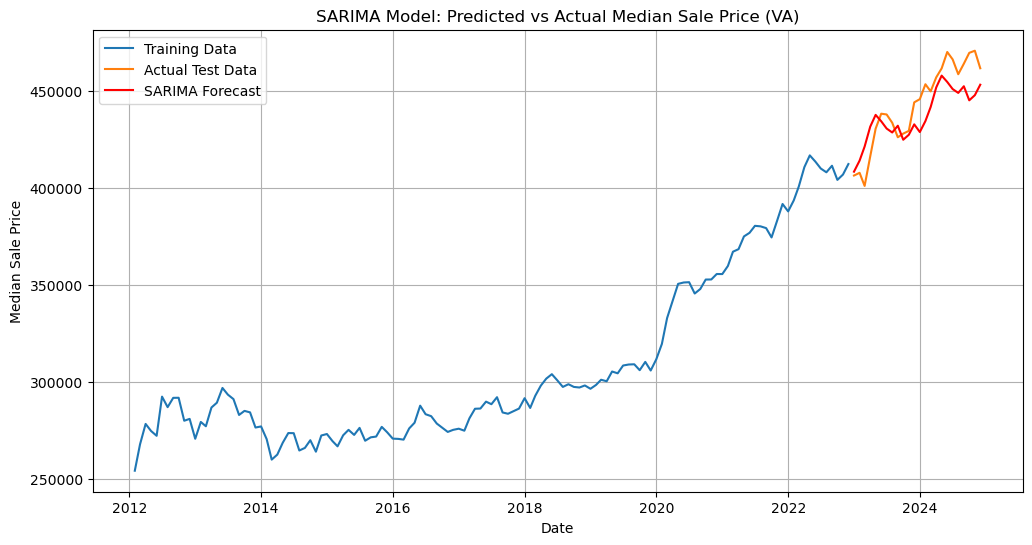

In [22]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute RMSE
rmse = sqrt(mean_squared_error(test['median_sale_price'], forecast))

# Compute MAE
mae = mean_absolute_error(test['median_sale_price'], forecast)

# Compute MAPE
mape = (abs((test['median_sale_price'] - forecast) / test['median_sale_price'])).mean() * 100

# Print the metrics
print(f"SARIMA Model RMSE: {rmse:.2f}")
print(f"SARIMA Model MAE: {mae:.2f}")
print(f"SARIMA Model MAPE: {mape:.2f}%")

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['median_sale_price'], label='Training Data')
plt.plot(test.index, test['median_sale_price'], label='Actual Test Data')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model: Predicted vs Actual Median Sale Price (VA)')
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
exog_columns = ['median_list_price', 'median_ppsf', 'homes_sold', 'inventory', 'median_dom']

# Prepare exogenous variables for training and testing
exog_train = train[exog_columns].fillna(method='ffill')
exog_test = test[exog_columns].fillna(method='ffill')

In [24]:
# Fit SARIMAX model
model_exog = SARIMAX(train['median_sale_price'], 
                     exog=exog_train,
                     order=(p, d, q), 
                     seasonal_order=(P, D, Q, s))
model_exog_fit = model_exog.fit(disp=False)

forecast_exog = model_exog_fit.forecast(steps=len(test), exog=exog_test)

SARIMAX Model with Exogenous Variables RMSE: 9763.21
SARIMAX Model with Exogenous Variables MAE: 7394.79
SARIMAX Model with Exogenous Variables MAPE: 1.70%


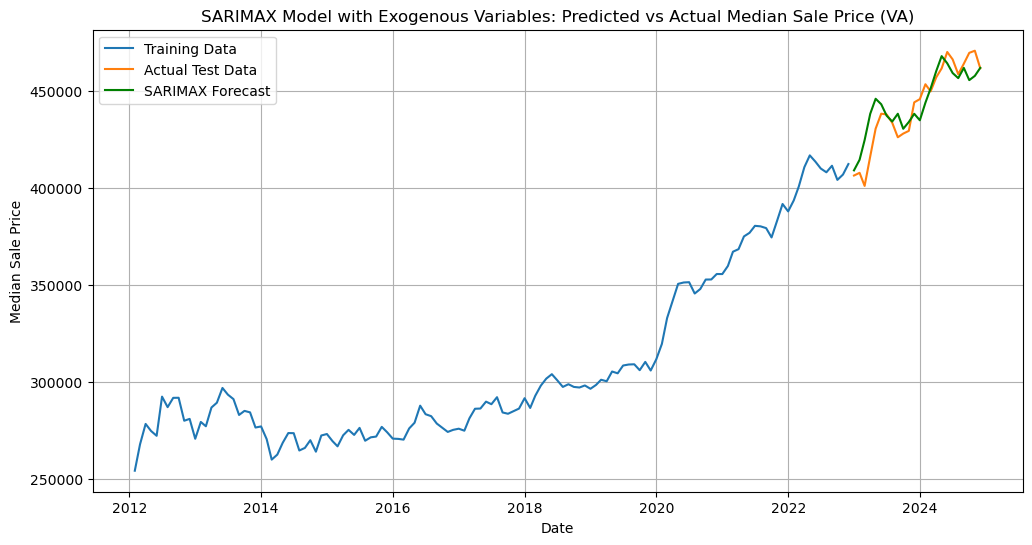

In [25]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute RMSE for SARIMAX model
rmse_exog = sqrt(mean_squared_error(test['median_sale_price'], forecast_exog))

# Compute MAE for SARIMAX model
mae_exog = mean_absolute_error(test['median_sale_price'], forecast_exog)

# Compute MAPE for SARIMAX model
mape_exog = (abs((test['median_sale_price'] - forecast_exog) / test['median_sale_price'])).mean() * 100

# Print the metrics for SARIMAX
print(f"SARIMAX Model with Exogenous Variables RMSE: {rmse_exog:.2f}")
print(f"SARIMAX Model with Exogenous Variables MAE: {mae_exog:.2f}")
print(f"SARIMAX Model with Exogenous Variables MAPE: {mape_exog:.2f}%")

# Plot results for SARIMAX
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['median_sale_price'], label='Training Data')
plt.plot(test.index, test['median_sale_price'], label='Actual Test Data')
plt.plot(test.index, forecast_exog, label='SARIMAX Forecast', color='green')
plt.title('SARIMAX Model with Exogenous Variables: Predicted vs Actual Median Sale Price (VA)')
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.legend()
plt.grid(True)
plt.show()


Future forecasted median sale prices for the next 3 years:
2022-12-31    413063.787526
2023-01-31    419704.388758
2023-02-28    428238.785159
2023-03-31    439237.909978
2023-04-30    446835.086091
2023-05-31    445210.708636
2023-06-30    441179.885175
2023-07-31    439799.567638
2023-08-31    443790.944753
2023-09-30    435271.965639
2023-10-31    435978.209422
2023-11-30    439738.679304
2023-12-31    435170.109452
2024-01-31    441765.532589
2024-02-29    450281.176644
2024-03-31    461150.449319
2024-04-30    468744.677186
2024-05-31    467165.254472
2024-06-30    463216.600383
2024-07-31    461889.644692
2024-08-31    465801.590914
2024-09-30    457240.958216
2024-10-31    458001.555158
2024-11-30    461801.691501
2024-12-31    457234.681615
2025-01-31    463847.275859
2025-02-28    472370.047230
2025-03-31    483288.673582
2025-04-30    490884.022006
2025-05-31    489287.513076
2025-06-30    485307.628384
2025-07-31    483960.391139
2025-08-31    487902.527134
2025-09-30    479

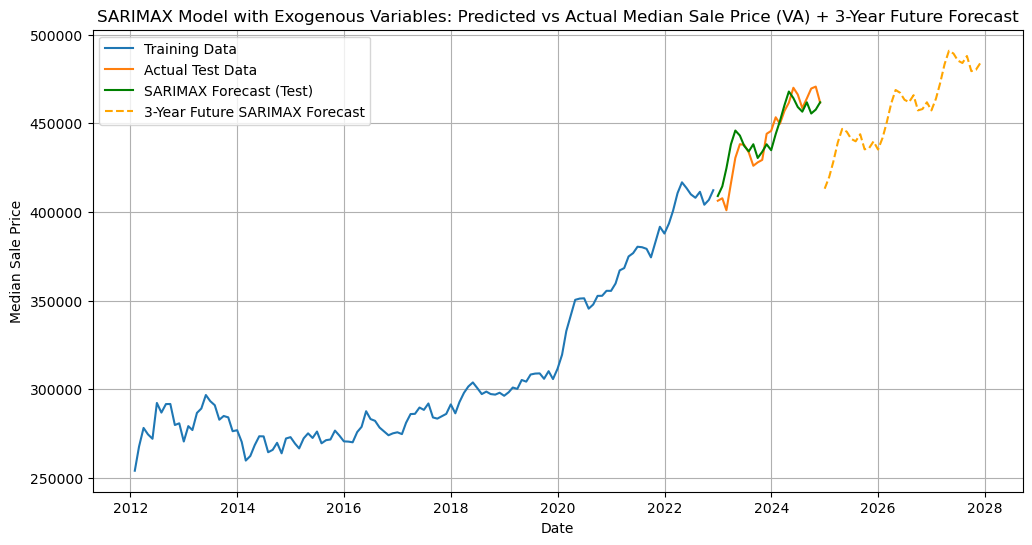

In [27]:
# Define how many steps into the future you want to forecast (3 years = 36 months)
forecast_steps = 36  # Forecasting 36 months (3 years) ahead

# Use the last available value for each exogenous variable as the future values
last_known_exog_values = exog_test.iloc[-1]  # Get the last row of the exogenous variables

# Create a DataFrame for the future exogenous variables (repeating the last known values for the forecast period)
future_exog_df = pd.DataFrame(
    [last_known_exog_values] * forecast_steps,  # Repeat the last known values for 36 months
    columns=exog_columns,
    index=pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')  # Create future dates
)

# Forecast future values using the fitted SARIMAX model
forecast_future = model_exog_fit.forecast(steps=forecast_steps, exog=future_exog_df)

# Print the forecasted future prices
print("Future forecasted median sale prices for the next 3 years:")
print(forecast_future)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['median_sale_price'], label='Training Data')
plt.plot(test.index, test['median_sale_price'], label='Actual Test Data')
plt.plot(test.index, forecast_exog, label='SARIMAX Forecast (Test)', color='green')
plt.plot(future_exog_df.index, forecast_future, label='3-Year Future SARIMAX Forecast', color='orange', linestyle='--')
plt.title('SARIMAX Model with Exogenous Variables: Predicted vs Actual Median Sale Price (VA) + 3-Year Future Forecast')
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.legend()
plt.grid(True)
plt.show()


SARIMA Model RMSE: 12359.27
SARIMA Model MAE: 10440.73
SARIMA Model MAPE: 2.34%


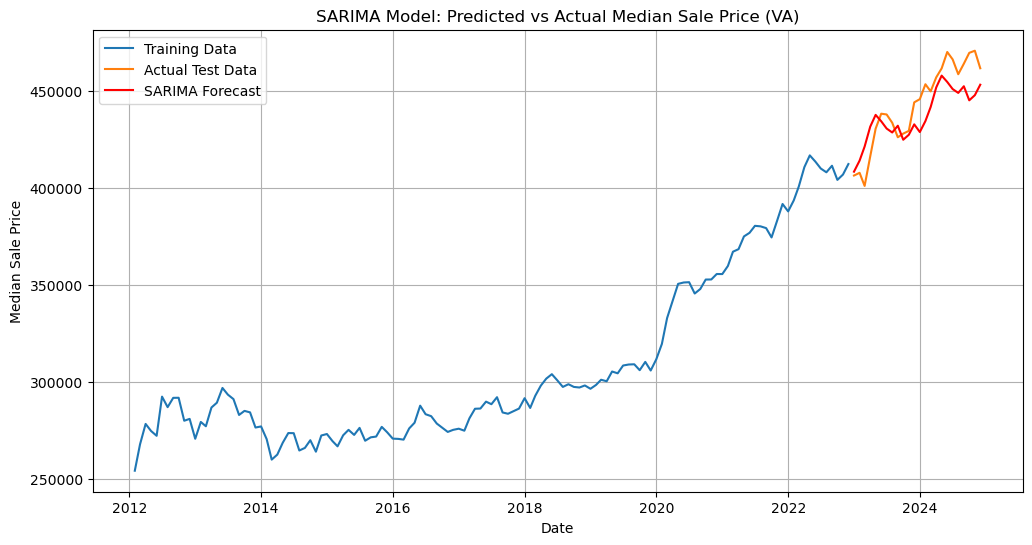

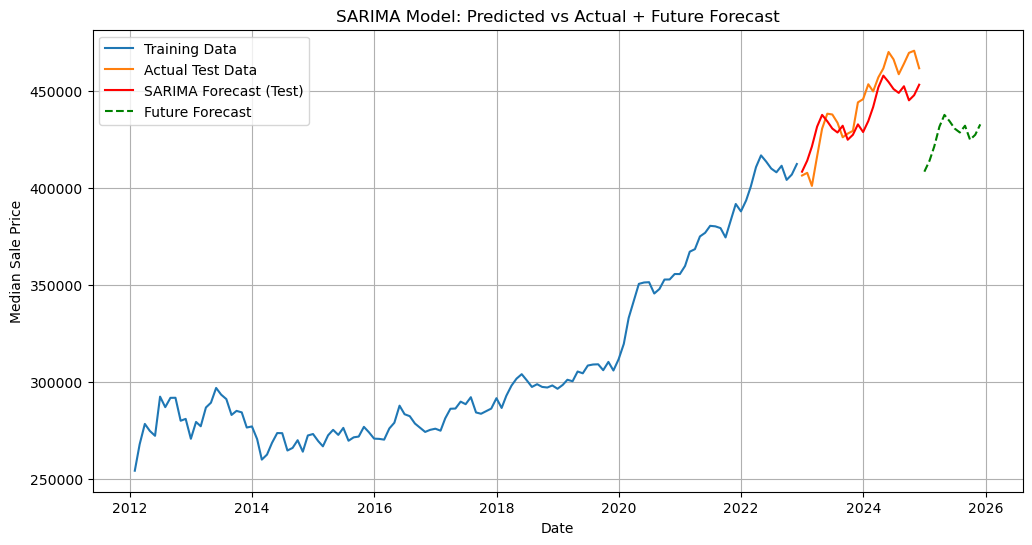

Future forecasted values:
2022-12-31    408269.490002
2023-01-31    413968.787416
2023-02-28    421232.618428
2023-03-31    431485.787451
2023-04-30    437562.336907
2023-05-31    434261.150395
2023-06-30    430519.336540
2023-07-31    428486.107128
2023-08-31    431971.534645
2023-09-30    424742.048890
2023-10-31    427302.821835
2023-11-30    432677.409147
Freq: ME, Name: predicted_mean, dtype: float64


In [40]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute RMSE
rmse = sqrt(mean_squared_error(test['median_sale_price'], forecast))

# Compute MAE
mae = mean_absolute_error(test['median_sale_price'], forecast)

# Compute MAPE
mape = (abs((test['median_sale_price'] - forecast) / test['median_sale_price'])).mean() * 100

# Print the metrics
print(f"SARIMA Model RMSE: {rmse:.2f}")
print(f"SARIMA Model MAE: {mae:.2f}")
print(f"SARIMA Model MAPE: {mape:.2f}%")

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['median_sale_price'], label='Training Data')
plt.plot(test.index, test['median_sale_price'], label='Actual Test Data')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model: Predicted vs Actual Median Sale Price (VA)')
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.legend()
plt.grid(True)
plt.show()

# Now, for future forecasting:
# Forecast the next 12 months (or any number of future steps you want)
future_steps = 12  # for example, forecast the next 12 months
forecast_future = model_fit.forecast(steps=future_steps)

# Generate the future forecast plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['median_sale_price'], label='Training Data')
plt.plot(test.index, test['median_sale_price'], label='Actual Test Data')
plt.plot(test.index, forecast, label='SARIMA Forecast (Test)', color='red')
future_dates = pd.date_range(start=test.index[-1], periods=future_steps + 1, freq='M')[1:]  # generate future dates
plt.plot(future_dates, forecast_future, label='Future Forecast', color='green', linestyle='--')
plt.title('SARIMA Model: Predicted vs Actual + Future Forecast')
plt.xlabel('Date')
plt.ylabel('Median Sale Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecasted future values
print("Future forecasted values:")
print(forecast_future)
